## Machine Learning Coursework (Part 1)

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- don't use libraries that implement kNN or cross-validation.  We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking 

The grades in this coursework are allocated approximately as follows:

|                                                    | mark  |  
|----------------------------------------------------|-------|
| Data exploration (+ 2 questions)                   | 10     |  
| Code, docu. & comments (KNN + Evaluation + NCV)    | 10    |  
| Results (KNN folds + Summary + Confusion matrices) | 10     |  
| Final questions:                                   | 10     |  
| Overall quality & use of Markdown                  | 10     |  
| Total available                                    |**50** |  


## 1. Exploratory Data Analysis 

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with. 

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

The following image shows what such a visualisation might look like on the Iris dataset that you worked on during the Topic exercises. 

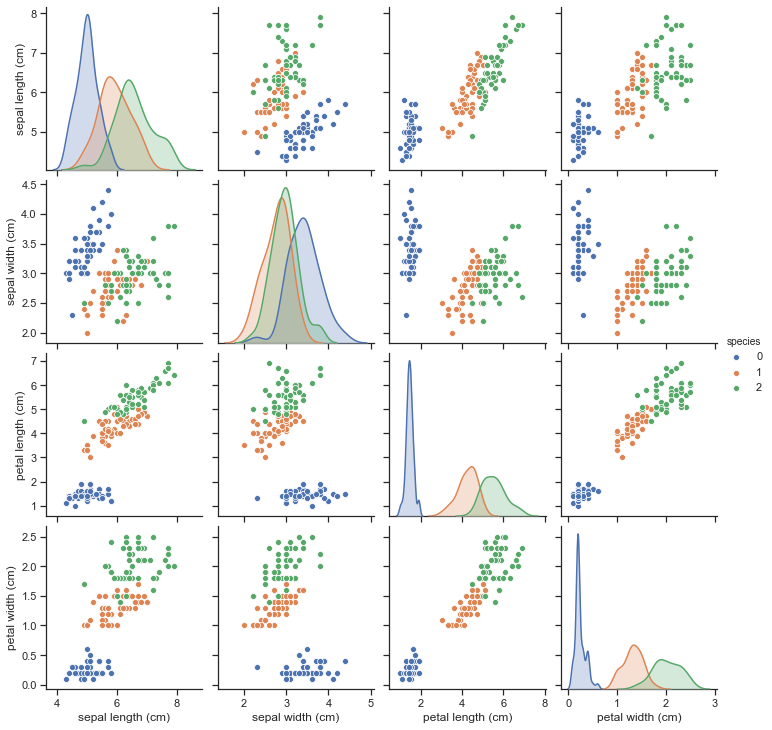

Your first task is to recreate a similar grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.     

You should create a function that, given data X and labels y, plots this grid.  The function should be invoked something like this:
        
    myplotGrid(X,y,...)
    
where X is your training data and y are the labels (you may also supply additional optional arguments). You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this. 


In [2]:
# define plotting function
##additional library to help
import seaborn as sns

def myplotGrid(X,y):
    new_df = pd.DataFrame(X,columns = selected_features)
    new_df['Class of wine'] = y
    sns.pairplot(new_df,hue = 'Class of wine', palette='flare')

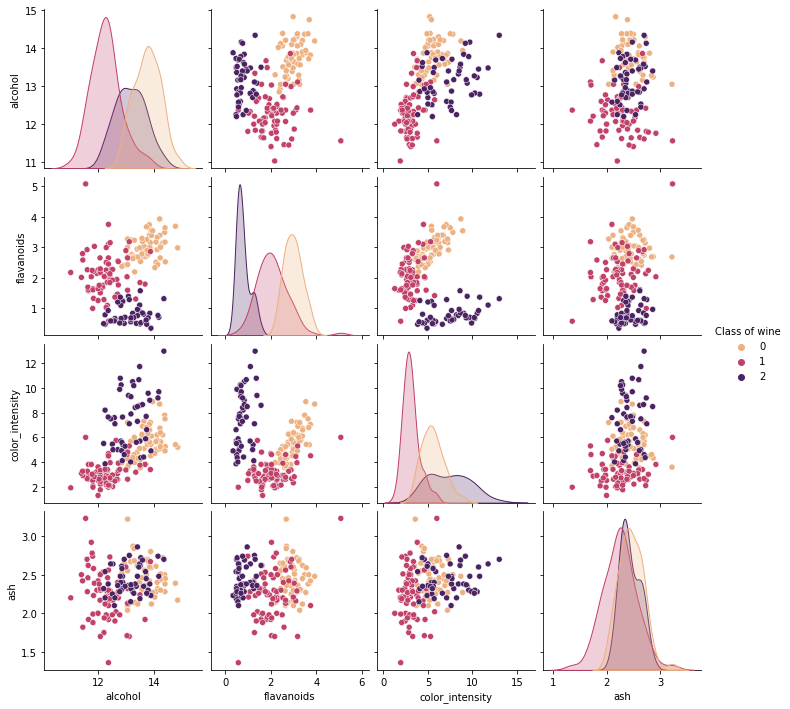

In [3]:
# run the plotting function
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.6,X.shape)
    
and then invoke

    myplotGrid(XN,y)

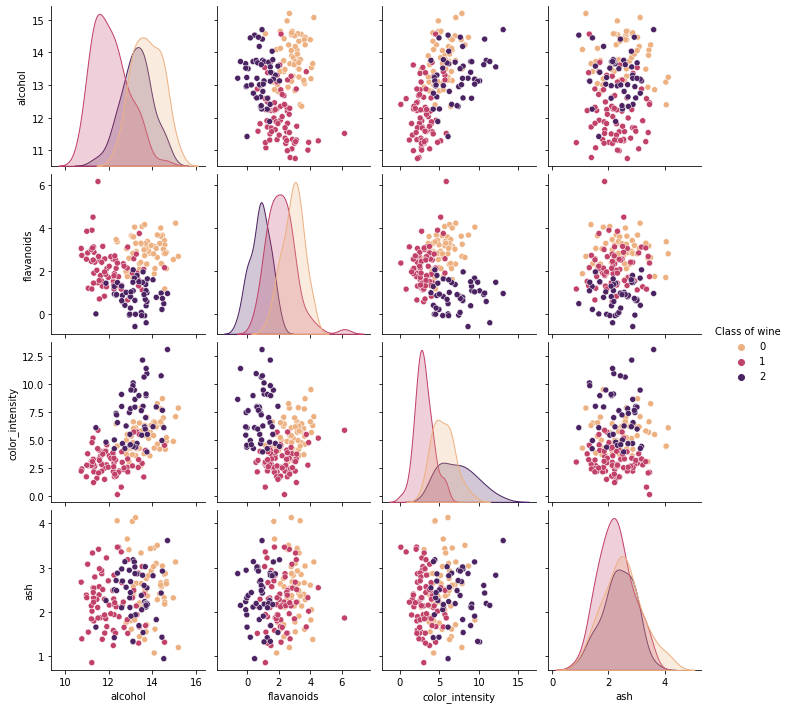

In [4]:
# noise code
mySeed = 28109
np.random.seed(mySeed)
XN=X+np.random.normal(0,0.6,X.shape)

#run plot
myplotGrid(XN,y)


### Q1. Exploratory data analysis
Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why?  Answer as fully as you can. 


answer: <br>
Classification requires us to test the model to see if it can differentiate the data into distinct groups. Thus, color intensity and flavanoids are the two features I would choose, as there is a clear difference between the grouping of points plotted for each of the classes. This would make the data points easily distinguishable and making it good for test a model on.



### Q2. Data with noise
What do you observe by plotting the data without noise compared to plotting with added Gaussian noise? 


answer:<br>
When plotting with added Gaussian noise, the spread of the points in each group is larger compared to plotting without noise.



## 2. Implementing kNN 

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions. 

Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector. 


In [5]:
# helper code
#Implementing manual kNN

#import additional libraries
import math, random
import numpy as np
from collections import Counter

#Distance Functions

##Euclidean distance
def euclidean_dist(a, b):
    return np.linalg.norm(a - b, axis = 0)

##Manhattan distance
def manhattan_dist(a,b):
    assert len(a) == len(b), "Vectors must be of the same length"
    dist = 0
    for i in range(0, len(a)):
        dist += math.fabs(a[i] - b[i])
    return dist

##Train test and split
def my_train_test_split(X, y, testSize):
    #test the test size value
    assert (testSize > 0.0 and testSize < 1.0), "Test size must be between 0 and 1"
    #Shuffle X and y
    mySeed=1234567
    np.random.seed(mySeed)
    index = np.arange(X.shape[0])
    index = np.random.permutation(index)
    X = X[index]
    y = y[index]
    #Split X and y using the cut point calculated via the test size fraction
    cut_point = int(len(X)*(testSize))
    X_test = X[0:cut_point]
    y_test = y[0:cut_point]
    X_train = X[cut_point:]
    y_train = y[cut_point:]
    return (X_train, X_test, y_train, y_test)

#manual kNN function
def mykNN(X_train,y_train,X_test,k,distance_type):
    predicted=[]
    #Fit and predict
    for x in X_test: 
        neighbours=[[],[]]
        #Distances between all data points
        if distance_type.lower() =="euclidean":
            distances = [euclidean_dist(x, j) for j in X_train]
        elif distance_type.lower() == "manhattan":
            distances = [manhattan_dist(x, j) for j in X_train]
        #Indices of the smallest k in neighbours
        k_nearest_ids = np.argsort(distances)[:k]
        #Labels
        k_nearest_labels = [y_train[m] for m in k_nearest_ids]
        #Count labels
        counts = np.bincount(k_nearest_labels)
        #Predicted is class with the most counts
        predicted.append(np.argmax(counts))
    return np.array(predicted)

In [6]:
# mykNN code

## Split
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 0.5)

## Get predicted values
y_ = mykNN(X_train, y_train, X_test,5, "euclidean")

print("Predicted: ")
print(y_)
print("\n")
print("Actual: ")
print(y_test)

Predicted: 
[2 0 0 0 1 0 0 1 1 0 2 1 2 1 0 1 2 0 2 2 1 0 1 0 2 0 0 0 0 1 1 1 2 0 2 0 2
 0 0 0 0 0 2 0 0 2 2 0 1 0 2 0 1 1 0 2 1 0 1 0 1 0 2 1 1 1 0 1 0 1 1 1 2 2
 0 1 1 2 0 1 1 0 0 2 2 1 0 0 0]


Actual: 
[2 0 0 1 1 0 0 1 1 0 2 1 2 1 0 1 2 0 2 2 1 1 1 0 2 0 0 0 0 1 1 1 2 0 2 1 2
 0 0 0 0 0 2 0 0 2 1 0 1 0 2 0 1 1 0 2 1 0 1 0 1 0 2 1 1 1 1 1 0 1 1 2 2 2
 0 1 1 2 0 1 1 0 0 2 2 1 0 0 0]


## 3. Classifier evaluation 

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions. 


In [14]:
# confusion matrix, accuracy, precision, recall, etc. 
def myConfMatrix (y_test,y_pred,nClasses):
    #Initialize n dimensional matrix of zeros
    CM = np.zeros((nClasses,nClasses),dtype=int)
    for i in range(0, len(y_pred)):
        CM[y_test[i]][y_pred[i]] +=1
    return CM

def myPrecision(y_test,y_pred):
    #Array of classes
    classes = np.unique(y_pred)
    #Number of classes
    n= len(classes)
    #Intialize array of zeros for class by class results
    precision = np.zeros(classes.shape)
    #Confusion matrix
    conf_matrix = myConfMatrix(y_test,y_pred,n)
    #loop over results and classes
    for i in range(0,n):
        #Initialize true positive + false positive
        tp_plus_fp = 0
        for j in classes:
            #True positive + false positives
            tp_plus_fp+=conf_matrix[j][i]
        #precision = true positives / true positives + false positives
        class_precision=conf_matrix[i][i]/tp_plus_fp
        precision[i]=class_precision
    return precision

def myRecall(y_test,y_pred):
    #Array of classes
    classes = np.unique(y_pred)
    #Number of classes
    n= len(classes)
    #Initialize array of zeros for output
    recall = np.zeros(classes.shape)
    #Confusion matrix
    conf_matrix = myConfMatrix (y_test,y_pred,n)
    for i in range(0,n):
        #Initialize true positive plus false negative
        tp_plus_fn=0
        for j in classes:
            #true positives + false negatives
            tp_plus_fn+=conf_matrix[i][j]
        #recall = true positives / true positives + false negatives
        class_recall=conf_matrix[i][i]/tp_plus_fn
        recall[i]=class_recall
    return recall

def myAccuracy(y_test,y_pred):
    #accuracy = correct predictions/total predictions
    accuracy = len(y_test[np.where(y_test==y_pred)])/len(y_pred)
    return accuracy

print ('diy function:')
print ("accuracy:  %0.3f" % myAccuracy(y_test,y_))
print ("classes:    %s " % np.unique(y_))
print ("precision: %s" % myPrecision(y_test,y_))
print ("recall:    %s \n\n" % myRecall(y_test,y_)) 

diy function:
accuracy:  0.933
classes:    [0 1 2] 
precision: [0.8974359  0.96551724 0.95238095]
recall:    [1.         0.84848485 0.95238095] 




In [19]:
# test evaluation code

#scikit's kNN:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.5, random_state=1234567)
knn=KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train1,y_train1)
y_pred1=knn.predict(X_test1)

print ('scikit function:')
print ("accuracy:  %0.3f" % myAccuracy(y_test1, y_pred1))
print ("classes:    %s " % np.unique(y_pred1))
print ("precision: %s" % myPrecision(y_test1,y_pred1))
print ("recall:    %s \n\n" % myRecall(y_test1,y_pred1)) 


scikit function:
accuracy:  0.933
classes:    [0 1 2] 
precision: [0.8974359  0.96551724 0.95238095]
recall:    [1.         0.84848485 0.95238095] 





## 4. Nested Cross-validation using your implementation of KNN  

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on **both** your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [20]:
# myNestedCrossVal code
def myNestedCrossVal(X, y, foldK, nns, dists, mySeed):
    np.random.seed(mySeed)
    accuracy_fold=[]
    parameters_fold=[]
    conf_matrices=[]
    #Generate a list of shuffled indices with np.random.permutation
    L=list(range(X.shape[0]) )
    indices = np.random. permutation(L)
    #Split the indices to foldK different bins (here, 5)
    #uncomment line below
    bins=np.array_split(indices, foldK)
    #print(bins)
    
    assert(foldK==len(bins))
    #loop through folds
    for i in range(0,foldK):
        #list to store current indices for training
        foldTrain=[]
        #list to store current indices for testing
        foldTest=[] 
        #list to store current indices for validation
        foldVal=[] 
        
        #loop through all bins, take bin i for testing, the next bin for validation, and the rest for training
        valBin = (i+1)%foldK
        for j in range(0,len(bins)):
            if (i ==j):
                foldTest = bins[i]
            elif (j == valBin):
                foldVal = bins[valBin]
            else:
                foldTrain.extend(bins[j])
                
        #store best values
        bestDistance=''
        bestNN=-1 
        bestAccuracy=-10
        
        #loop through all parameters
        for d in dists:
            for nn in nns:
                #train the classifier on current number of neighbours/distance
                #obtain results on validation set
                y_pred=mykNN(X[foldTrain],y[foldTrain],X[foldVal],nn,d)
                accuracy = myAccuracy(y[foldVal], y_pred)
                #save parameters if best possible results 
                if accuracy > bestAccuracy:
                    bestDistance = d
                    bestNN = nn
                    bestAccuracy = accuracy
                    
        #evaluate test data and extend training set with validation set
        foldTrain.extend(foldVal)
        #train k-NN classifier with new training set and test 
        y_=mykNN(X[foldTrain],y[foldTrain],X[foldTest],bestNN,bestDistance)
        #calculate accuracy of fold and append to accuracy_fold
        accuracy_ = myAccuracy(y[foldTest],y_)
        accuracy_fold.append(accuracy_)
        #store parameters
        parameters_fold.append((bestDistance,bestNN))
        #number of classes
        nClasses = len(np.unique(y_))
        #store confusion matrix
        conf_matrix=myConfMatrix(y[foldTest],y_,nClasses)
        conf_matrices.append(conf_matrix)
    return accuracy_fold, parameters_fold, np.array(conf_matrices);

In [10]:
# evaluate clean data code
#Clean
#Nested crossval knn on clean data
dists=["euclidean", "manhattan"]
mySeed=123456
kFolds=5
#Nested crossval
accuracies_fold, best_parameters_fold, conf_matrices = myNestedCrossVal(X,y, kFolds, list(range(1,11)), dists, mySeed)
#Calculate average accuracy
avg_accuracy = np.average(accuracies_fold)
#Calculate standard deviation
sd = np.std(accuracies_fold)
# Formatting
import pandas
columns=(["accuracy", "k", "distance"])
rounded_accuracies=["{0:.2f}".format(i) for i in accuracies_fold]
dist_metrics=[best_parameters_fold[i][0] for i in range(0,len(best_parameters_fold))]
nns=[best_parameters_fold[i][1] for i in range(0,len(best_parameters_fold))]
data = np.array([rounded_accuracies,nns,dist_metrics])
df=pandas.DataFrame(data.T,np. arange(1, kFolds+1), columns)
print("Clean")
print("\nTotal accuracy: %8.3f +- %8.3f" % (avg_accuracy, sd))
df


Clean

Total accuracy:    0.927 +-    0.039


,accuracy,k,distance
1,0.97,3,euclidean
2,0.94,1,euclidean
3,0.92,1,euclidean
4,0.86,1,euclidean
5,0.94,2,manhattan


In [16]:
# evaluate noisy  data code
#Noisy
# Nested crossval knn  on noisy data
noisy_accuracies_fold, noisy_best_parameters_fold, noisy_conf_matrices = myNestedCrossVal(XN,y, kFolds, list(range(1,11)), dists, mySeed)
#Calculate average accuracy
noisy_avg_accuracy = np.average(noisy_accuracies_fold)
#Calculate standard deviation
sd1 = np.std(noisy_accuracies_fold)
# Formatting
columns=(["accuracy", "k", "distance"])
noisy_rounded_accuracies=["{0: .2f}".format(i) for i in noisy_accuracies_fold]
noisy_dist_metrics=[noisy_best_parameters_fold[i][0] for i in range(0,len(noisy_best_parameters_fold))]
noisy_nns=[noisy_best_parameters_fold[i][1] for i in range(0,len(noisy_best_parameters_fold))]
noisy_data =np.array([noisy_rounded_accuracies, noisy_nns, noisy_dist_metrics])
noisy_df=pandas.DataFrame(noisy_data.T,np.arange(1, kFolds+1), columns)
print("Noisy")
print("\nTotal accuracy: %8.3f +- %8.3f" % (noisy_avg_accuracy, sd1))
noisy_df


Noisy

Total accuracy:    0.866 +-    0.036


,accuracy,k,distance
1,0.86,1,euclidean
2,0.86,1,manhattan
3,0.81,8,manhattan
4,0.89,3,euclidean
5,0.91,9,euclidean


In [17]:
# Print the summaries
print("Clean")
print("\nTotal accuracy: %8.3f +- %8.3f" % (avg_accuracy, sd))
display(df)
print("Noisy")
print("\nTotal accuracy: %8.3f +- %8.3f" % (noisy_avg_accuracy, sd1))
display(noisy_df)

Clean

Total accuracy:    0.927 +-    0.039


,accuracy,k,distance
1,0.97,3,euclidean
2,0.94,1,euclidean
3,0.92,1,euclidean
4,0.86,1,euclidean
5,0.94,2,manhattan


Noisy

Total accuracy:    0.866 +-    0.036


,accuracy,k,distance
1,0.86,1,euclidean
2,0.86,1,manhattan
3,0.81,8,manhattan
4,0.89,3,euclidean
5,0.91,9,euclidean


## 5. Summary of results

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.97  |  3 | euclidean  |
| 2 | 0.94  |  1 | euclidean  |
| 3 | 0.92  |  1 | euclidean  |
| 4 | 0.86  |  1 | euclidean  |
| 5 | 0.94  |  2 | manhattan  |
| **total** | 0.927 $\pm$ 0.039 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.86  |  1 | euclidean  |
| 2 | 0.86  |  1 | manhattan  |
| 3 | 0.81  |  8 | manhattan  |
| 4 | 0.89  |  3 | euclidean  |
| 5 | 0.91  |  9 | euclidean  |
| **total** | 0.866  $\pm$ 0.036 |   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your ```myNestedCrossVal``` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall. 


In [18]:
def cmPrecision(conf_matrix):
    #classes
    classes = np.unique(y)
    #initialise array of zeros for results
    precision= np.zeros(classes.shape)
    #Loop over confusion matrices and calculate results
    for i in range(0,len(conf_matrix)):
        tp_plus_fp=0
        for j in classes:
            #true positives + false positivies
            tp_plus_fp+=conf_matrix[j][i]
        # precision = true positives / true positives + false positives
        class_precision = conf_matrix[i][i]/tp_plus_fp
        precision[i]=class_precision
    return precision

def cmRecall(conf_matrix):
    #classes
    classes = np.unique(y)
    #initialise array of zeros for results
    recall = np.zeros(classes.shape)
    #Loop over confusion matrices and calculate results
    for i in range(0,len(conf_matrix)):
        tp_plus_fn=0
        for j in classes:
            # true positives + false negatives
            tp_plus_fn+=conf_matrix[i][j]
        #recall = true positives/ true positives + false negatives
        class_recall=conf_matrix[i][i]/tp_plus_fn
        recall[i]=class_recall
    return recall

#print summary function
def summary_matrices_print(conf_matrices):
    conf=np.zeros(conf_matrices[0].shape)
    for c in conf_matrices:
        conf=np.add(conf,c)
    print("Summary confusion matrix of data: \n")
    print(conf,"\n")
    precision = cmPrecision(conf)
    print("Class-relative precision for classes (0,1,2): %s" %precision)
    recall = cmRecall(conf)
    print("Class-relative recall for classes (0,1,2): %s" %recall)

print("Clean\n")
summary_matrices_print(conf_matrices)
print("Accuracy: %8.2f"%avg_accuracy)
print("\n\nNoisy data\n")
summary_matrices_print(noisy_conf_matrices)
print("Accuracy: %8.2f"%noisy_avg_accuracy)

Clean

Summary confusion matrix of data: 

[[55.  4.  0.]
 [ 5. 64.  2.]
 [ 0.  2. 46.]] 

Class-relative precision for classes (0,1,2): [0.91666667 0.91428571 0.95833333]
Class-relative recall for classes (0,1,2): [0.93220339 0.90140845 0.95833333]
Accuracy:     0.93


Noisy data

Summary confusion matrix of data: 

[[53.  3.  3.]
 [10. 60.  1.]
 [ 4.  3. 41.]] 

Class-relative precision for classes (0,1,2): [0.79104478 0.90909091 0.91111111]
Class-relative recall for classes (0,1,2): [0.89830508 0.84507042 0.85416667]
Accuracy:     0.87


## 6. More questions 

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.



### Q3.	 Influence of noise
Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used? 


Answer:<br>
The best parameters change when noise is added to the data, with varied values of k, 3 Euclidean distance and 1 Manhattan distance. 
For the value of k, the best choice is dependent on the sample size and thus depends on the data. 
For the distance metric used, Euclidean distance is better for small dimensions but at higher dimensions, Manhattan distance is better. Thus, there is no one parameter choice that is better regardless of data used.



### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

Answer:<br>
In order to break the tie, we have to look at the classes of the neighbouring values, and take the nearest value's class.



<code>#use modulus to check for even number, and 2 or more unique neighbours
if len(neighbours)%2 == 0 and neighbours.unique() >= 2:
    #the first in the array would be the nearest neighbour
    newClass = neighbours[0]
</code>

### Q5.	Beyond Wine 
If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code. 


Answer: <br>
We would need to consider the dimensions of the dataset, the size of the sample, the variance of the data, and the relationships between features. <br>
Possible changes include the k value, the usage of Gaussian noise, addition of new distance metrics, and code to clean the data.

